# GNN для прогнозирования трафика по графу дорожной сети

In [1]:
%%capture
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torchmetrics

In [2]:
!pip install tqdm
from tqdm.notebook import tqdm

In [3]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import Data
# from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

from torch_geometric.nn import GATConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchmetrics
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError, R2Score

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

traffic_df = pd.read_parquet('/content/drive/MyDrive/traffic_data/processed_traffic_speed.parquet')

In [5]:
road_df = pd.read_parquet('/content/drive/MyDrive/traffic_data/road_network.parquet')

In [ ]:
# node_ids = pd.concat([road_df['snodeid'], road_df['enodeid']]).unique()
# node_id_map = {nid: idx for idx, nid in enumerate(node_ids)}
# edges = []
# for _, row in road_df.iterrows():
#     src = node_id_map.get(row['snodeid'])
#     dst = node_id_map.get(row['enodeid'])
#     if src is not None and dst is not None:
#         edges.append([src, dst])
# edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# for src, dst in zip(edge_index[0], edge_index[1]):
#     print(f"{src.item()} -> {dst.item()}")

In [6]:
link_ids = road_df['link_id'].unique()
link_id_to_idx = {lid: idx for idx, lid in enumerate(link_ids)}

#    - enodeid по link_id
#    - snodeid по link_id
linkid_to_enode = dict(zip(road_df['link_id'], road_df['enodeid']))
linkid_to_snode = dict(zip(road_df['link_id'], road_df['snodeid']))

In [ ]:
with open('/content/link_ids.pkl', 'wb') as f:
    pickle.dump(link_ids, f)

In [7]:
snode_to_linkids = {}
for lid in link_ids:
    snode = linkid_to_snode[lid]
    snode_to_linkids.setdefault(snode, []).append(lid)


In [8]:
# 3. Построим связи:
#    если конец одного сегмента (enode) совпадает с началом другого (snode) → можно перейти
edges = []
for lid_a in tqdm(link_ids, desc="Построение edge_index"):
    enode_a = linkid_to_enode[lid_a]
    if enode_a in snode_to_linkids:
        for lid_b in snode_to_linkids[enode_a]:
            src = link_id_to_idx[lid_a]
            dst = link_id_to_idx[lid_b]
            edges.append([src, dst])

Построение edge_index:   0%|          | 0/45148 [00:00<?, ?it/s]

In [9]:
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
print(f"Сформирован edge_index с {edge_index.shape[1]} связями между {len(link_ids)} сегментами (узлами).")

Сформирован edge_index с 49935 связями между 45148 сегментами (узлами).


In [ ]:
torch.save(edge_index, '/content/edge_index.pt')

In [10]:
feature_cols = [c for c in road_df.columns if c not in ['link_id', 'snodeid', 'enodeid']]
x_map = {
    row['link_id']: torch.tensor(
        pd.to_numeric(row[feature_cols], errors='coerce').fillna(0).values, dtype=torch.float32
    )
    for _, row in road_df.iterrows()
}

In [ ]:
with open('/content/x_map.pkl', 'wb') as f:
    pickle.dump(x_map, f)

In [ ]:
# # 1. Подготовим список timestamp-ов
# # Например, каждый 20-й шаг (~раз в 5 часов)
# timestamps = sorted(traffic_df['timestamp'].unique())[::20]  # 5856 → ~290

# # 2. Сгруппируем заранее по времени (ускоряет выборку)
# grouped = traffic_df.groupby('timestamp')

# # 3. Оставим только нужные link_id в x_map
# valid_links = set(traffic_df['road_segment_id'].unique())
# x_map_filtered = {lid: vec for lid, vec in x_map.items() if lid in valid_links}

# # 4. Подготовка
# graphs = []
# time_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

# for timestamp in tqdm(timestamps, desc="Генерация графов"):
#     if timestamp not in grouped.groups:
#         continue

#     sample = grouped.get_group(timestamp)

#     x_list, y_list = [], []
#     for i, row in sample.iterrows():
#         lid = row['road_segment_id']
#         if lid in x_map_filtered:
#             road_feat = x_map_filtered[lid]
#             time_feat = torch.tensor(row[time_cols].astype(float).values, dtype=torch.float32)
#             x = torch.cat([road_feat, time_feat])
#             x_list.append(x)
#             y_list.append(torch.tensor(row['traffic_speed'], dtype=torch.float32))

#     if x_list and y_list:
#         x_tensor = torch.stack(x_list)
#         y_tensor = torch.stack(y_list)
#         data = Data(x=x_tensor, edge_index=edge_index, y=y_tensor)
#         graphs.append(data)

# print(f"Сгенерировано {len(graphs)} графов (timestamp-ов)")

In [ ]:
grouped = traffic_df.groupby('timestamp')
valid_links = set(traffic_df['road_segment_id'].unique())
x_map_filtered = {lid: vec for lid, vec in x_map.items() if lid in valid_links}
timestamps = sorted(traffic_df['timestamp'].unique())[::2]
graphs_2 = []
time_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
for timestamp in tqdm(timestamps, desc="Генерация графов"):
    if timestamp not in grouped.groups:
        continue
    sample = grouped.get_group(timestamp)
    sample_array = sample[['road_segment_id'] + time_cols + ['traffic_speed']].values
    x_list, y_list, lid_list = [], [], []
    for row in sample_array:
        lid = int(row[0])
        if lid in x_map_filtered:
            road_feat = x_map_filtered[lid]
            time_feat = torch.tensor(row[1:5], dtype=torch.float32)
            x = torch.cat([road_feat, time_feat])
            x_list.append(x)
            y_list.append(torch.tensor(row[5], dtype=torch.float32))
            lid_list.append(lid)
    if not x_list:
        continue
    x_tensor = torch.stack(x_list)
    y_tensor = torch.stack(y_list)
    # Построение локального графа
    lid_to_local = {lid: idx for idx, lid in enumerate(lid_list)}
    local_edges = []
    for src_idx, dst_idx in zip(edge_index[0], edge_index[1]):
        src_lid = link_ids[src_idx]
        dst_lid = link_ids[dst_idx]
        if src_lid in lid_to_local and dst_lid in lid_to_local:
            local_edges.append([lid_to_local[src_lid], lid_to_local[dst_lid]])
    if not local_edges:
        continue

    edge_index_tensor = torch.tensor(local_edges, dtype=torch.long).t().contiguous()
    graphs_2.append(Data(x=x_tensor, edge_index=edge_index_tensor, y=y_tensor))

print(f"Сгенерировано {len(graphs_2)} графов по {len(timestamps)} timestamp'ам.")

Генерация графов:   0%|          | 0/2928 [00:00<?, ?it/s]

✅ Сгенерировано 2928 графов по 2928 timestamp'ам.


In [ ]:
import pickle

# Сохраняем графы в файл
with open('/content/graphs_2.pkl', 'wb') as f:
    pickle.dump(graphs_2, f)

print("Графы успешно сохранены в graphs_2.pkl")

✅ Графы успешно сохранены в graphs_2.pkl


In [ ]:
from google.colab import files
files.download('/content/graphs_2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import zipfile
with zipfile.ZipFile('/content/graphs_2.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
  zipf.write('/content/graphs_2.pkl', arcname='graphs_2.pkl')
  print('done')

done


In [ ]:
# with open("/content/drive/MyDrive/traffic_data/graphs_1.pkl", "wb") as f:
#   pickle.dump(graphs_2, f)

# Подбор параметров

In [11]:
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/traffic_data/graphs_2.zip'
extract_path = '/content/graphs_2.pkl'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')


with open(extract_path, 'rb') as f:
    graphs_2 = pickle.load(f)

print(f"Загружено {len(graphs_2)} графов.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Загружено 2928 графов.


In [12]:
train_graphs, val_graphs = train_test_split(graphs_2, test_size=0.2, random_state=42)

In [13]:
class TrafficGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        # Attention-based свертки
        self.gat1 = GATConv(in_channels, hidden_channels, heads=2, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_channels * 2)
        self.dropout1 = nn.Dropout(p=0.3)

        self.gat2 = GATConv(hidden_channels * 2, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.dropout2 = nn.Dropout(p=0.3)

        # Финальный слой
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.gat2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        return self.lin(x).squeeze(-1)

In [14]:
metrics_config = {
    "MAE": MeanAbsoluteError(),
    "RMSE": MeanSquaredError(squared=False),  # RMSE = sqrt(MSE)
    "R2": R2Score()
}

In [ ]:
max_speed = traffic_df['traffic_speed'].max()
print(f"Максимальная скорость: {max_speed:.2f} км/ч")

Максимальная скорость: 120.00 км/ч


In [15]:
normalize_y = lambda y: y / 120.0
denormalize_y = lambda y: y * 120.0

In [16]:
def calculate_mape(pred, target):
    base = torch.clamp(target, min=5.0)
    return torch.mean(torch.abs((pred - target) / base)) * 100

In [ ]:
model = TrafficGNN(in_channels=graphs_2[0].x.shape[1], hidden_channels=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# scheduler: снижает lr в 10 раз, если val loss не улучшается 5 эпох
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_metrics_history = {"MAE": [], "RMSE": [], "R2": []}
val_metrics_history = {"MAE": [], "MAPE": [], "RMSE": [], "R2": []}

early_stop_patience = 10
best_val_loss = float('inf')
best_epoch = 0
epochs_no_improve = 0

for epoch in range(30):
    model.train()
    # total_train_loss, total_train_mae = 0, 0
    total_metrics_train = {name: 0.0 for name in metrics_config.keys()}
    total_metrics_train["MAPE"] = 0.0
    total_metrics_val = {name: 0.0 for name in metrics_config.keys()}
    total_metrics_val["MAPE"] = 0.0

    for data in train_graphs:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(out, normalize_y(data.y))
        loss.backward()
        optimizer.step()

        pred = denormalize_y(out)
        for name, metric in metrics_config.items():
            total_metrics_train[name] += metric(pred, data.y).item()

        total_metrics_train["MAPE"] += calculate_mape(pred, data.y).item()


    # avg_train_loss = total_train_loss / len(train_graphs)
    # avg_train_mae = total_train_mae / len(train_graphs)

    avg_metrics_train = {name: val / len(train_graphs) for name, val in total_metrics_train.items()}
    for name in train_metrics_history:
        train_metrics_history[name].append(avg_metrics_train[name])

    # валидация
    model.eval()
    with torch.no_grad():
        for data in val_graphs:
            out = model(data.x, data.edge_index)
            pred = denormalize_y(out)
            # Compute torchmetrics metrics
            for name, metric in metrics_config.items():
                total_metrics_val[name] += metric(pred, data.y).item()
            # Compute MAPE separately
            total_metrics_val["MAPE"] += calculate_mape(pred, data.y).item()

    avg_metrics_val = {name: val / len(val_graphs) for name, val in total_metrics_val.items()}
    for name in val_metrics_history:
        val_metrics_history[name].append(avg_metrics_val[name])

    # scheduler шаг
    # scheduler.step(avg_val_loss)
    scheduler.step(avg_metrics_val["MAE"])

    # early stopping
    # if avg_val_loss < best_val_loss:
    #     best_val_loss = avg_val_loss
    #     best_epoch = epoch
    #     epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1
    #     if epochs_no_improve >= early_stop_patience:
    #         print(f"Early stopping на эпохе {epoch} (лучшая — {best_epoch})")
    #         break

    if avg_metrics_val["MAE"] < best_val_loss:
        best_val_loss = avg_metrics_val["MAE"]
        best_epoch = epoch
        epochs_no_improve = 0
        # torch.save(model.state_dict(), '/content/best_traffic_gnn_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping на эпохе {epoch} (лучшая — {best_epoch})")
            break

    # вывод
    print(f"Epoch {epoch}: "
          f"Train MAE = {avg_metrics_train['MAE']:.2f} км/ч, Train RMSE = {avg_metrics_train['RMSE']:.2f} км/ч, Train R2 = {avg_metrics_train['R2']:.2f}, "
          f"Val MAE = {avg_metrics_val['MAE']:.2f} км/ч, Val MAPE = {avg_metrics_val['MAPE']:.2f}%, Val RMSE = {avg_metrics_val['RMSE']:.2f} км/ч, Val R2 = {avg_metrics_val['R2']:.2f}")

    # # вывод
    # print(f"Epoch {epoch}: Train MAE = {avg_train_mae:.2f} км/ч, "
    #       f"Val MAE = {avg_val_mae:.2f} км/ч | Val MAPE = {avg_val_mape:.2f}%")

Epoch 0: Train MAE = 7.67 км/ч, Train RMSE = 9.97 км/ч, Train R2 = 0.14, Val MAE = 7.04 км/ч, Val MAPE = 25.99%, Val RMSE = 9.27 км/ч, Val R2 = 0.32
Epoch 1: Train MAE = 7.36 км/ч, Train RMSE = 9.56 км/ч, Train R2 = 0.28, Val MAE = 7.11 км/ч, Val MAPE = 25.72%, Val RMSE = 9.24 км/ч, Val R2 = 0.33
Epoch 2: Train MAE = 7.45 км/ч, Train RMSE = 9.67 км/ч, Train R2 = 0.27, Val MAE = 7.07 км/ч, Val MAPE = 25.54%, Val RMSE = 9.19 км/ч, Val R2 = 0.33
Epoch 3: Train MAE = 7.48 км/ч, Train RMSE = 9.71 км/ч, Train R2 = 0.26, Val MAE = 7.17 км/ч, Val MAPE = 27.00%, Val RMSE = 9.35 км/ч, Val R2 = 0.30
Epoch 4: Train MAE = 7.49 км/ч, Train RMSE = 9.72 км/ч, Train R2 = 0.26, Val MAE = 7.10 км/ч, Val MAPE = 26.31%, Val RMSE = 9.21 км/ч, Val R2 = 0.33
Epoch 5: Train MAE = 7.49 км/ч, Train RMSE = 9.72 км/ч, Train R2 = 0.26, Val MAE = 7.08 км/ч, Val MAPE = 25.76%, Val RMSE = 9.20 км/ч, Val R2 = 0.33
Epoch 6: Train MAE = 7.48 км/ч, Train RMSE = 9.70 км/ч, Train R2 = 0.26, Val MAE = 7.11 км/ч, Val MAPE = 2

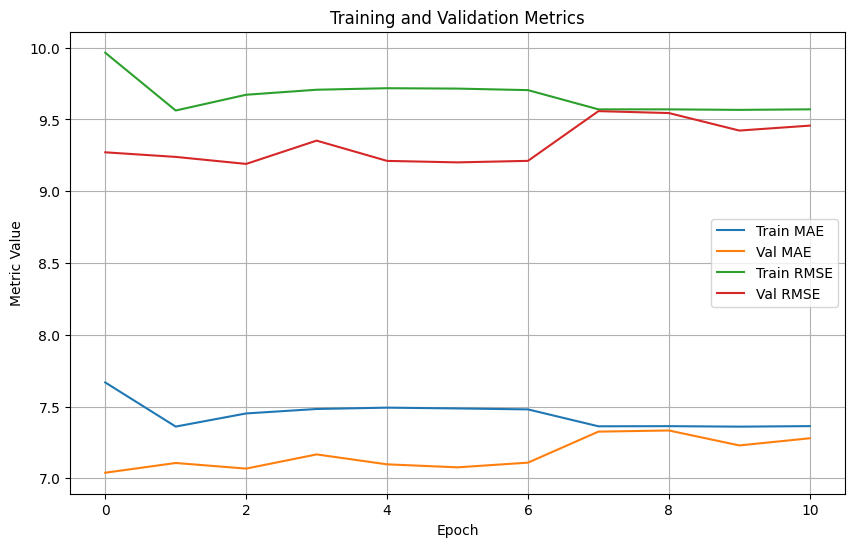

In [ ]:
epochs = range(len(train_metrics_history['MAE']))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_metrics_history['MAE'], label='Train MAE')
plt.plot(epochs, val_metrics_history['MAE'], label='Val MAE')
plt.plot(epochs, train_metrics_history['RMSE'], label='Train RMSE')
plt.plot(epochs, val_metrics_history['RMSE'], label='Val RMSE')
# plt.plot(epochs, train_metrics_history['R2'], label='Train R2')
# plt.plot(epochs, val_metrics_history['R2'], label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/traffic_gnn_model1.pt')

# Батч больше 1

In [23]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=False)
val_loader = DataLoader(val_graphs, batch_size=16, shuffle=False)

In [24]:
model = TrafficGNN(in_channels=graphs_2[0].x.shape[1], hidden_channels=64)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)

# scheduler: снижает lr в 10 раз, если val loss не улучшается 5 эпох
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_metrics_history = {"MAE": [], "RMSE": [], "R2": []}
val_metrics_history = {"MAE": [], "MAPE": [], "RMSE": [], "R2": []}
early_stop_patience = 10
best_val_loss = float('inf')
best_epoch = 0
epochs_no_improve = 0

for epoch in range(15):
    model.train()
    total_metrics_train = {name: 0.0 for name in metrics_config.keys()}
    total_metrics_train["MAPE"] = 0.0
    total_metrics_val = {name: 0.0 for name in metrics_config.keys()}
    total_metrics_val["MAPE"] = 0.0

    # Обучающий цикл
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = F.mse_loss(out, normalize_y(batch.y))
        loss.backward()
        optimizer.step()

        pred = denormalize_y(out)
        for name, metric in metrics_config.items():
            total_metrics_train[name] += metric(pred, batch.y).item()  # Используем batch.y
        total_metrics_train["MAPE"] += calculate_mape(pred, batch.y).item()

    avg_metrics_train = {name: val / len(train_loader) for name, val in total_metrics_train.items()}
    for name in train_metrics_history:
        train_metrics_history[name].append(avg_metrics_train[name])

    # Валидационный цикл
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            out = model(batch.x, batch.edge_index)
            pred = denormalize_y(out)
            for name, metric in metrics_config.items():
                total_metrics_val[name] += metric(pred, batch.y).item()  # Используем batch.y
            total_metrics_val["MAPE"] += calculate_mape(pred, batch.y).item()

    avg_metrics_val = {name: val / len(val_loader) for name, val in total_metrics_val.items()}
    for name in val_metrics_history:
        val_metrics_history[name].append(avg_metrics_val[name])

    scheduler.step(avg_metrics_val["MAE"])

    if avg_metrics_val["MAE"] < best_val_loss:
        best_val_loss = avg_metrics_val["MAE"]
        best_epoch = epoch
        epochs_no_improve = 0
        torch.save(model.state_dict(), '/content/best_traffic_gnn_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"Early stopping на эпохе {epoch} (лучшая — {best_epoch})")
            break

    print(f"Epoch {epoch}: "
          f"Train MAE = {avg_metrics_train['MAE']:.2f}, Train RMSE = {avg_metrics_train['RMSE']:.2f}, Train R2 = {avg_metrics_train['R2']:.2f}, "
          f"Val MAE = {avg_metrics_val['MAE']:.2f}, Val MAPE = {avg_metrics_val['MAPE']:.2f}, Val RMSE = {avg_metrics_val['RMSE']:.2f}, Val R2 = {avg_metrics_val['R2']:.2f}")

Epoch 0: Train MAE = 15.10, Train RMSE = 19.12, Train R2 = -2.80, Val MAE = 7.36, Val MAPE = 23.56, Val RMSE = 9.81, Val R2 = 0.30
Epoch 1: Train MAE = 7.39, Train RMSE = 9.68, Train R2 = 0.33, Val MAE = 6.93, Val MAPE = 23.73, Val RMSE = 9.13, Val R2 = 0.39
Epoch 2: Train MAE = 7.05, Train RMSE = 9.25, Train R2 = 0.39, Val MAE = 6.85, Val MAPE = 24.89, Val RMSE = 8.95, Val R2 = 0.41
Epoch 3: Train MAE = 6.95, Train RMSE = 9.10, Train R2 = 0.41, Val MAE = 6.86, Val MAPE = 25.06, Val RMSE = 8.94, Val R2 = 0.42
Epoch 4: Train MAE = 6.99, Train RMSE = 9.11, Train R2 = 0.40, Val MAE = 6.90, Val MAPE = 25.36, Val RMSE = 8.95, Val R2 = 0.41


KeyboardInterrupt: 

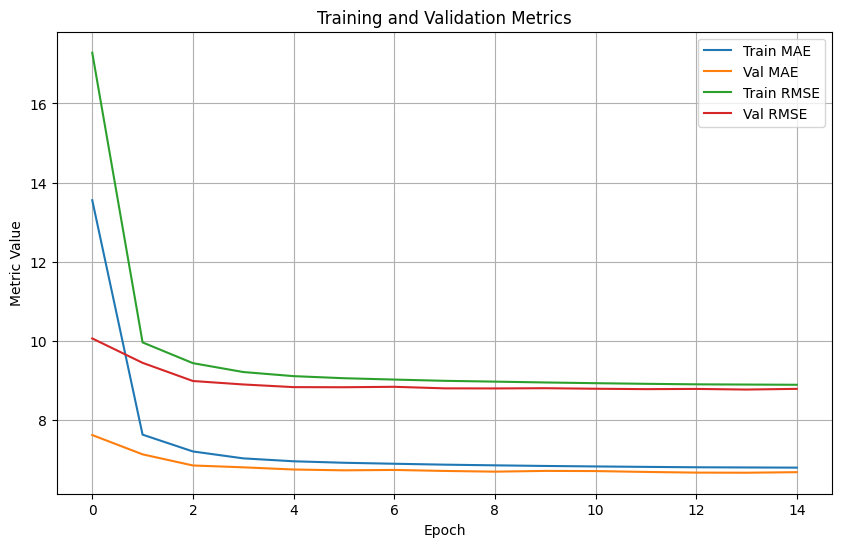

In [22]:
epochs = range(len(train_metrics_history['MAE']))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_metrics_history['MAE'], label='Train MAE')
plt.plot(epochs, val_metrics_history['MAE'], label='Val MAE')
plt.plot(epochs, train_metrics_history['RMSE'], label='Train RMSE')
plt.plot(epochs, val_metrics_history['RMSE'], label='Val RMSE')
# plt.plot(epochs, train_metrics_history['R2'], label='Train R2')
# plt.plot(epochs, val_metrics_history['R2'], label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True)
plt.show()

# Старый раздел

In [ ]:
log_text = """
Epoch 0: Train MAE = 7.66 км/ч, Val MAE = 7.06 км/ч | Val MAPE = 26.24%
Epoch 1: Train MAE = 7.37 км/ч, Val MAE = 7.02 км/ч | Val MAPE = 25.23%
Epoch 2: Train MAE = 7.45 км/ч, Val MAE = 7.07 км/ч | Val MAPE = 25.76%
Epoch 3: Train MAE = 7.49 км/ч, Val MAE = 7.09 км/ч | Val MAPE = 26.29%
Epoch 4: Train MAE = 7.50 км/ч, Val MAE = 7.19 км/ч | Val MAPE = 26.98%
Epoch 5: Train MAE = 7.51 км/ч, Val MAE = 7.06 км/ч | Val MAPE = 26.06%
Epoch 6: Train MAE = 7.49 км/ч, Val MAE = 7.10 км/ч | Val MAPE = 26.19%
Epoch 7: Train MAE = 7.50 км/ч, Val MAE = 7.08 км/ч | Val MAPE = 26.03%
Epoch 8: Train MAE = 7.38 км/ч, Val MAE = 7.29 км/ч | Val MAPE = 27.97%
Epoch 9: Train MAE = 7.37 км/ч, Val MAE = 7.40 км/ч | Val MAPE = 28.75%
Epoch 10: Train MAE = 7.38 км/ч, Val MAE = 7.40 км/ч | Val MAPE = 28.68%
Early stopping на эпохе 11 (лучшая — 1)
"""
import re
epochs = []
train_mae = []
val_mae = []
val_mape = []

for line in log_text.strip().split('\n'):
    match = re.search(r"Epoch (\d+): Train MAE = ([\d.]+) км/ч, Val MAE = ([\d.]+) км/ч \| Val MAPE = ([\d.]+)%", line)
    if match:
        e, tr, va, mp = match.groups()
        epochs.append(int(e))
        train_mae.append(float(tr))
        val_mae.append(float(va))
        val_mape.append(float(mp))

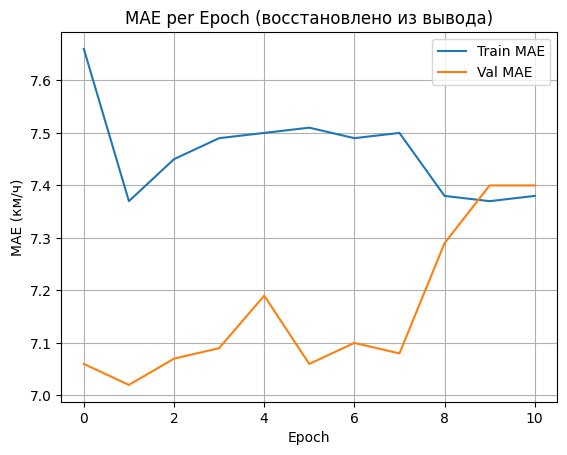

In [ ]:
plt.plot(epochs, train_mae, label='Train MAE')
plt.plot(epochs, val_mae, label='Val MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE (км/ч)")
plt.title("MAE per Epoch (восстановлено из вывода)")
plt.legend()
plt.grid(True)
plt.show()

# Тестовый инференс

In [ ]:
datetime_str = "2025-05-06 06:15"
route_link_ids = [123456, 123789, 124000, 1542179399, 1562548955]  # список link_id по маршруту

In [ ]:
import datetime
import numpy as np

def get_time_features(dt):
    hour = dt.hour + dt.minute / 60.0
    day_of_week = dt.weekday()
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    dow_sin = np.sin(2 * np.pi * day_of_week / 7)
    dow_cos = np.cos(2 * np.pi * day_of_week / 7)
    return torch.tensor([hour_sin, hour_cos, dow_sin, dow_cos], dtype=torch.float32)

In [ ]:
dt = datetime.datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")
time_feat = get_time_features(dt)

# сбираем x: для всех узлов из x_map
x_all = []
lid_to_idx = {}  # индекс в x - link_id

for i, (lid, road_feat) in enumerate(x_map.items()):
    full_feat = torch.cat([road_feat, time_feat])
    x_all.append(full_feat)
    lid_to_idx[i] = lid

x_tensor = torch.stack(x_all)

model.eval()
with torch.no_grad():
    y_pred = model(x_tensor, edge_index)

y_pred = model(x_tensor, edge_index) * 120.0 # нормализуем

linkid_to_pred = {lid_to_idx[i]: float(y_pred[i]) for i in range(len(y_pred))}


print("Предсказанная скорость (км/ч) по маршруту:")
for lid in route_link_ids:
    if lid in linkid_to_pred:
        print(f"  link_id {lid}: {linkid_to_pred[lid]:.2f} км/ч")
    else:
        print(f"  link_id {lid}: нет данных / не входит в граф")

Предсказанная скорость (км/ч) по маршруту:
  link_id 123456: ❌ нет данных / не входит в граф
  link_id 123789: ❌ нет данных / не входит в граф
  link_id 124000: ❌ нет данных / не входит в граф
  link_id 1542179399: 34.99 км/ч
  link_id 1562548955: 30.73 км/ч
